In [1]:
# This code is used to compute the MSE
# between predicted shape and actual shape
# Steps involves:
# 1. Fold the original image horizontally at the center
# (Mirror the top part on to the bottom and add,
# then give pixel value 1 to all values other than 0)
# 2. Fold the predicted image similarly 
# (Mirror the top part on to the bottom and add,
# then normalize the image)

# Last section contains the all the functions to fold and calc MSE
# Other sections are used to experiment with the code

In [2]:
# Import necessary libraries

# Import TF and check for GPU

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import save_model, load_model
import sys


2024-01-12 12:21:25.593582: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-12 12:21:26.509874: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/abraham/miniconda3/envs/tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.12.1


In [3]:
tf.keras.backend.clear_session()

In [4]:
# test_shape_dir  = '../data/data_npy/shape_npy/shape_filled8.npy'
# test_shape = np.load(test_shape_dir)
# # Normalize the image, convert to opacity map
# ## Test Set
# test_shape = test_shape/np.amax(test_shape)
# test_shape_where_0 = np.where(test_shape == 0)
# test_shape_where_1 = np.where(test_shape == 1)
# test_shape[test_shape_where_0] = 1  # 1 represent the shape (1 opacity)
# test_shape[test_shape_where_1] = 0  # 0 represent background (0 opacity)

test Set: No. of LC = No. of shapes
Extended the light curves


2024-01-12 12:21:29.461275: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7214 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2024-01-12 12:21:32.023972: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


SNR = 500. Loss -> 0.11103931069374084
8/8 [==============================] - 2s 91ms/step
SNR = 200. Loss -> 0.11950487643480301
8/8 [==============================] - 0s 6ms/step
SNR = 150. Loss -> 0.12359504401683807
8/8 [==============================] - 0s 7ms/step
SNR = 100. Loss -> 0.13307219743728638
8/8 [==============================] - 0s 6ms/step
SNR = 75. Loss -> 0.13805019855499268
8/8 [==============================] - 0s 6ms/step
SNR = 50. Loss -> 0.1533011794090271
8/8 [==============================] - 0s 5ms/step
k =  0
k =  1
k =  2
k =  3
k =  4


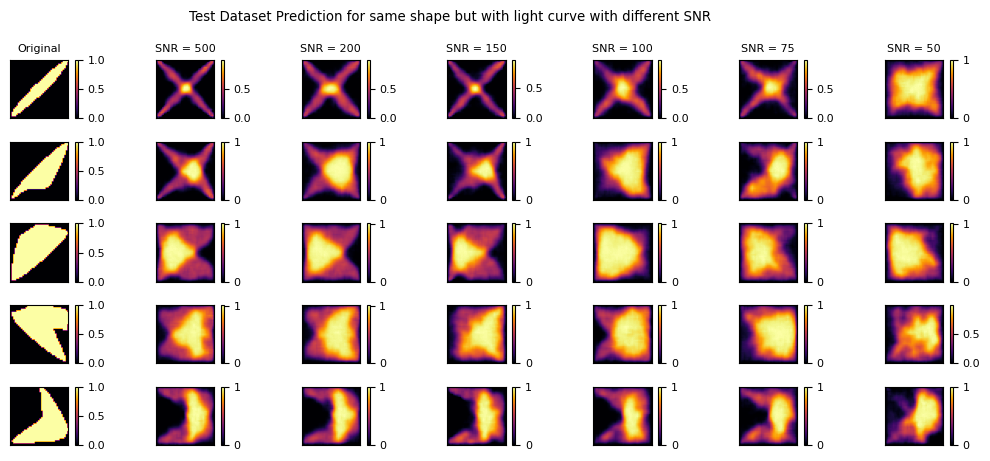

In [5]:
# Load Test Dataset
# test_shape_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/shape_npy/shape_filled8.npy'
# test_lc_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/lc_npy/lc_dict_8.npy'
test_lc_dir = '../data/data_npy/lc_npy/lc_dict_8.npy'
test_shape_dir  = '../data/data_npy/shape_npy/shape_filled8.npy'


test_lc = np.load(test_lc_dir)
test_shape = np.load(test_shape_dir)
# Check equality of number of dataset
if len(test_lc)==len(test_shape):
    print("test Set: No. of LC = No. of shapes")
else:
    sys.exit("EXIT: testn Set: No. of LC != No. of shapes")

# Normalize the image, convert to opacity map
## Test Set
test_shape = test_shape/np.amax(test_shape)
test_shape_where_0 = np.where(test_shape == 0)
test_shape_where_1 = np.where(test_shape == 1)
test_shape[test_shape_where_0] = 1  # 1 represent the shape (1 opacity)
test_shape[test_shape_where_1] = 0  # 0 represent background (0 opacity)


# Normalize the lightcurves
## - Test Set
test_lc_scaled = np.zeros(test_lc.shape)
for i in np.arange(len(test_lc_scaled)):
    test_lc_scaled[i] = (test_lc[i] - np.amin(test_lc[i]))/(np.amax(test_lc[i]) - np.amin(test_lc[i]))

# Append with ones
## - Test Set
test_lc_scaled_append = np.ones((test_lc.shape[0],120))
for i in np.arange(len(test_lc_scaled)):
    test_lc_scaled_append[i,10:110] = test_lc_scaled[i]
print("Extended the light curves")

# Function to Add noise to Test light curve
def add_noise(test_lc_scaled_append,SNR):
    std_dev = 1/SNR
    test_lc_scaled_append_noise = np.ones(test_lc_scaled_append.shape)
    rng = np.random.default_rng()

    for i in np.arange(len(test_lc_scaled_append)):
        noise_temp = np.random.normal(loc=0.0, scale=std_dev, size=len(test_lc_scaled_append[i]))
        rng.shuffle(noise_temp)
        test_lc_scaled_append_noise[i] = test_lc_scaled_append[i] + noise_temp
    return test_lc_scaled_append_noise

# Add noise to the light curve
test_lc_SNR500 =add_noise(test_lc_scaled_append,SNR=500)
test_lc_SNR200 =add_noise(test_lc_scaled_append,SNR=200)
test_lc_SNR150 =add_noise(test_lc_scaled_append,SNR=150)
test_lc_SNR100 =add_noise(test_lc_scaled_append,SNR=100)
test_lc_SNR75 =add_noise(test_lc_scaled_append,SNR=75)
test_lc_SNR50 =add_noise(test_lc_scaled_append,SNR=50)
# test_lc_SNR35 =add_noise(test_lc_scaled_append,SNR=35)
# test_lc_SNR20 =add_noise(test_lc_scaled_append,SNR=20)

# Experiment 2
# Switch on one MODEL and test on LC with different SNR
# Function to normalize predicted shape
def normalize_shape(test_predict_shape):
    test_predict_shape_normalized = np.zeros(test_predict_shape.shape)
    for i in np.arange(len(test_predict_shape)):
        test_predict_shape_normalized[i] = (test_predict_shape[i] - np.amin(test_predict_shape[i]))/(np.amax(test_predict_shape[i]) - np.amin(test_predict_shape[i]))
    print("Normalized the predicted shape")
    return test_predict_shape_normalized

#Load ML model
tf.keras.backend.clear_session()
model_SNR = load_model("../ml_model/sep22_singleModel_uniform_SNR/model_sep22_unf_50_500_v1.h5")

results = model_SNR.evaluate(test_lc_SNR500, test_shape, batch_size=128,verbose=0)
print("SNR = 500. Loss ->",results)
test_predict_shape_SNR500 = model_SNR.predict(test_lc_SNR500)
test_predict_shape_SNR500 = normalize_shape(test_predict_shape_SNR500)

results = model_SNR.evaluate(test_lc_SNR200, test_shape, batch_size=128,verbose=0)
print("SNR = 200. Loss ->",results)
test_predict_shape_SNR200 = model_SNR.predict(test_lc_SNR200)
test_predict_shape_SNR200 = normalize_shape(test_predict_shape_SNR200)

results = model_SNR.evaluate(test_lc_SNR150, test_shape, batch_size=128,verbose=0)
print("SNR = 150. Loss ->",results)
test_predict_shape_SNR150 = model_SNR.predict(test_lc_SNR150)
test_predict_shape_SNR150 = normalize_shape(test_predict_shape_SNR150)

results = model_SNR.evaluate(test_lc_SNR100, test_shape, batch_size=128,verbose=0)
print("SNR = 100. Loss ->",results)
test_predict_shape_SNR100 = model_SNR.predict(test_lc_SNR100)
test_predict_shape_SNR100 = normalize_shape(test_predict_shape_SNR100)

results = model_SNR.evaluate(test_lc_SNR75, test_shape, batch_size=128,verbose=0)
print("SNR = 75. Loss ->",results)
test_predict_shape_SNR75 = model_SNR.predict(test_lc_SNR75)
test_predict_shape_SNR75 = normalize_shape(test_predict_shape_SNR75)

results = model_SNR.evaluate(test_lc_SNR50, test_shape, batch_size=128,verbose=0)
print("SNR = 50. Loss ->",results)
test_predict_shape_SNR50 = model_SNR.predict(test_lc_SNR50)
test_predict_shape_SNR50 = normalize_shape(test_predict_shape_SNR50)

# Plot predicted shapes
num = 5
fig,ax=plt.subplots(num,7, figsize=(13,5), gridspec_kw={ 'width_ratios': [1,1,1,1,1,1,1],
        'wspace': 0.1,'hspace': 0.4})
plt.rcParams['figure.dpi'] = 1000
plt.rcParams.update({'font.size': 8})

ax[0][0].set_title('Original',size=8)
ax[0][1].set_title('SNR = 500',size=8)
ax[0][2].set_title('SNR = 200',size=8)
ax[0][3].set_title('SNR = 150',size=8)
ax[0][4].set_title('SNR = 100',size=8)
ax[0][5].set_title('SNR = 75',size=8)
ax[0][6].set_title('SNR = 50',size=8)



temp = np.linspace(0, len(test_lc_scaled_append)-1,len(test_lc_scaled_append))
index_test_array = np.random.choice(temp, size=(num,), replace=False)

for i in range(num):
    k =  i # int(index_test_array[i]) # random.randint(0, len(test_lc_scaled_append)-1) # i
    print("k = ",k)
    ax[i][0].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][3].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][4].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][5].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][6].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)

    img = ax[i][0].imshow(test_shape[k],cmap='inferno')
    plt.colorbar(img)  

    img = ax[i][1].imshow(test_predict_shape_SNR500[k],cmap='inferno')
    plt.colorbar(img)   

    img = ax[i][2].imshow(test_predict_shape_SNR200[k],cmap='inferno')
    plt.colorbar(img)   

    img = ax[i][3].imshow(test_predict_shape_SNR150[k],cmap='inferno')
    plt.colorbar(img)     

    img = ax[i][4].imshow(test_predict_shape_SNR100[k],cmap='inferno')
    plt.colorbar(img)  

    img = ax[i][5].imshow(test_predict_shape_SNR75[k],cmap='inferno')
    plt.colorbar(img)     

    img = ax[i][6].imshow(test_predict_shape_SNR50[k],cmap='inferno')
    plt.colorbar(img)

plt.suptitle('Test Dataset Prediction for same shape but with light curve with different SNR')
plt.show()

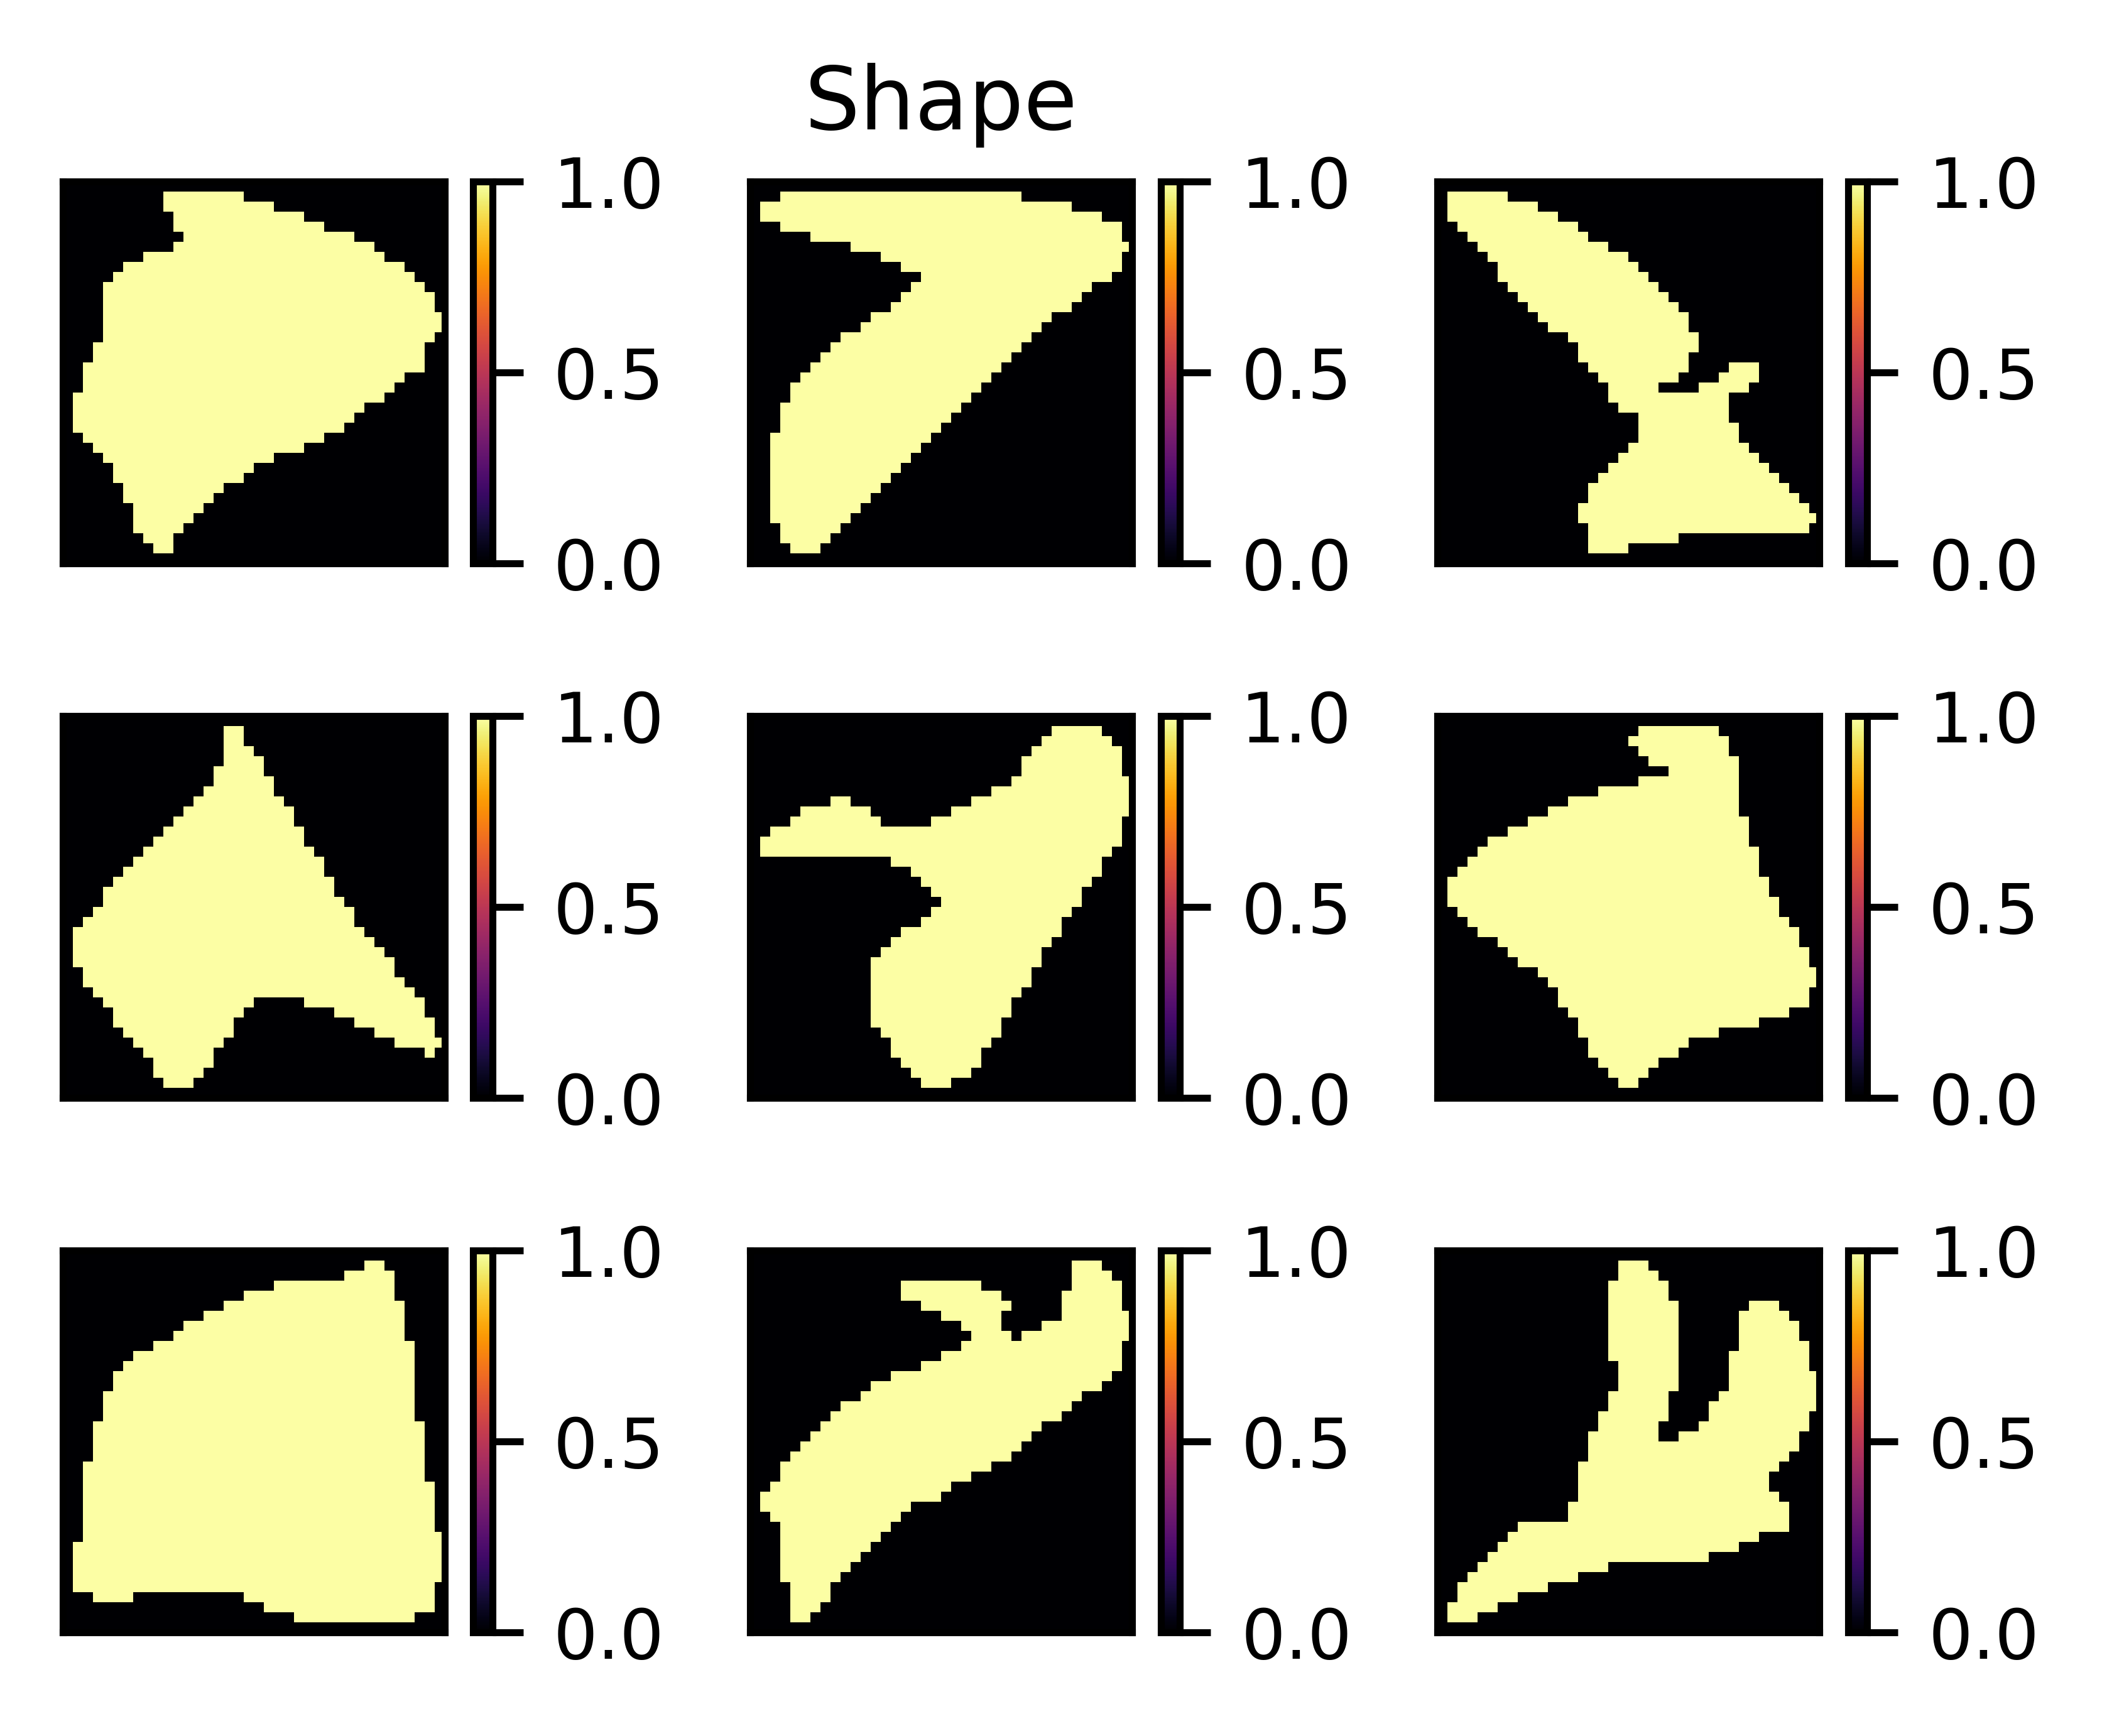

In [6]:
# Verification
num = 3
fig,ax=plt.subplots(num,3, figsize=(4,3), gridspec_kw={ 'width_ratios': [1,1,1],
        'wspace': 0.2,'hspace': 0.4})
plt.rcParams['figure.dpi'] = 400

ax[0][1].set_title('Shape',size=10)

# advance = 60

i = 0
for i in np.arange(0,num):
    k = np.random.randint(0, len(test_shape)-1)
    ax[i][0].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    img = ax[i][0].imshow(test_shape[k],cmap='inferno')
    plt.colorbar(img)
    
    k = np.random.randint(0, len(test_shape)-1)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    img = ax[i][1].imshow(test_shape[k],cmap='inferno')
    plt.colorbar(img)
    
    k = np.random.randint(0, len(test_shape)-1)
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    img = ax[i][2].imshow(test_shape[k],cmap='inferno')
    plt.colorbar(img)

    i = i + 1

In [7]:
# def fold_original_image(org_image):
#     # Fold a single dataset shape
#     # image = np.zeros((int(org_image.shape[0]/2),int(org_image.shape[1])))
#     image_top = org_image[0:int(org_image.shape[0]/2),:]
#     image_bottom = org_image[int(org_image.shape[0]/2):,:]
#     image_bottom_flip = np.flipud(image_bottom)
#     folded_image = image_bottom_flip+image_top
#     # folded_image_normalized = (folded_image - np.amin(folded_image))/(np.amax(folded_image) - np.amin(folded_image))
#     folded_image[folded_image>0] = 1
#     return(folded_image)


# # Code to test the above function
# index_compare = 19
# original_test = test_shape[int(index_compare)]
# fold_test_shape = fold_original_image(original_test)

# print("fold_test_shape.shape = ",fold_test_shape.shape)

# fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# original = test_shape[0]
# im = ax[0].imshow(original_test, cmap='inferno')
# ax[0].set_title('Original image')
# plt.colorbar(im)

# im = ax[1].imshow(fold_test_shape, cmap='inferno')
# ax[1].set_title('Normalized output')
# plt.colorbar(im)

# plt.show()

In [8]:
# def fold_predicted_image(predicted_image):
#     # Fold a single predicted image
#     image_top = predicted_image[0:int(predicted_image.shape[0]/2),:]
#     image_bottom = predicted_image[int(predicted_image.shape[0]/2):,:]
#     image_bottom_flip = np.flipud(image_bottom)
#     folded_predicted_image = image_bottom_flip+image_top
#     folded_image_normalized = (folded_predicted_image - np.amin(folded_predicted_image))/(np.amax(folded_predicted_image) - np.amin(folded_predicted_image))
#     # folded_image[folded_image>0] = 1
#     return(folded_image_normalized)


# # Code to test the above function
# original_predict = test_predict_shape_SNR500[int(index_compare)]
# folded_predicted_image = fold_predicted_image(original_predict)
# print("folded_predicted_image.shape = ",folded_predicted_image.shape)

# fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# im = ax[0].imshow(original_predict, cmap='inferno')
# ax[0].set_title('Original image')
# plt.colorbar(im)

# im = ax[1].imshow(folded_predicted_image, cmap='inferno')
# ax[1].set_title('Normalized output')
# plt.colorbar(im)

# plt.show()

In [9]:
# MSE = np.mean((fold_test_shape-folded_predicted_image)**2)
# print(MSE)

# MSE = np.mean((original_test-original_predict)**2)
# print(MSE)

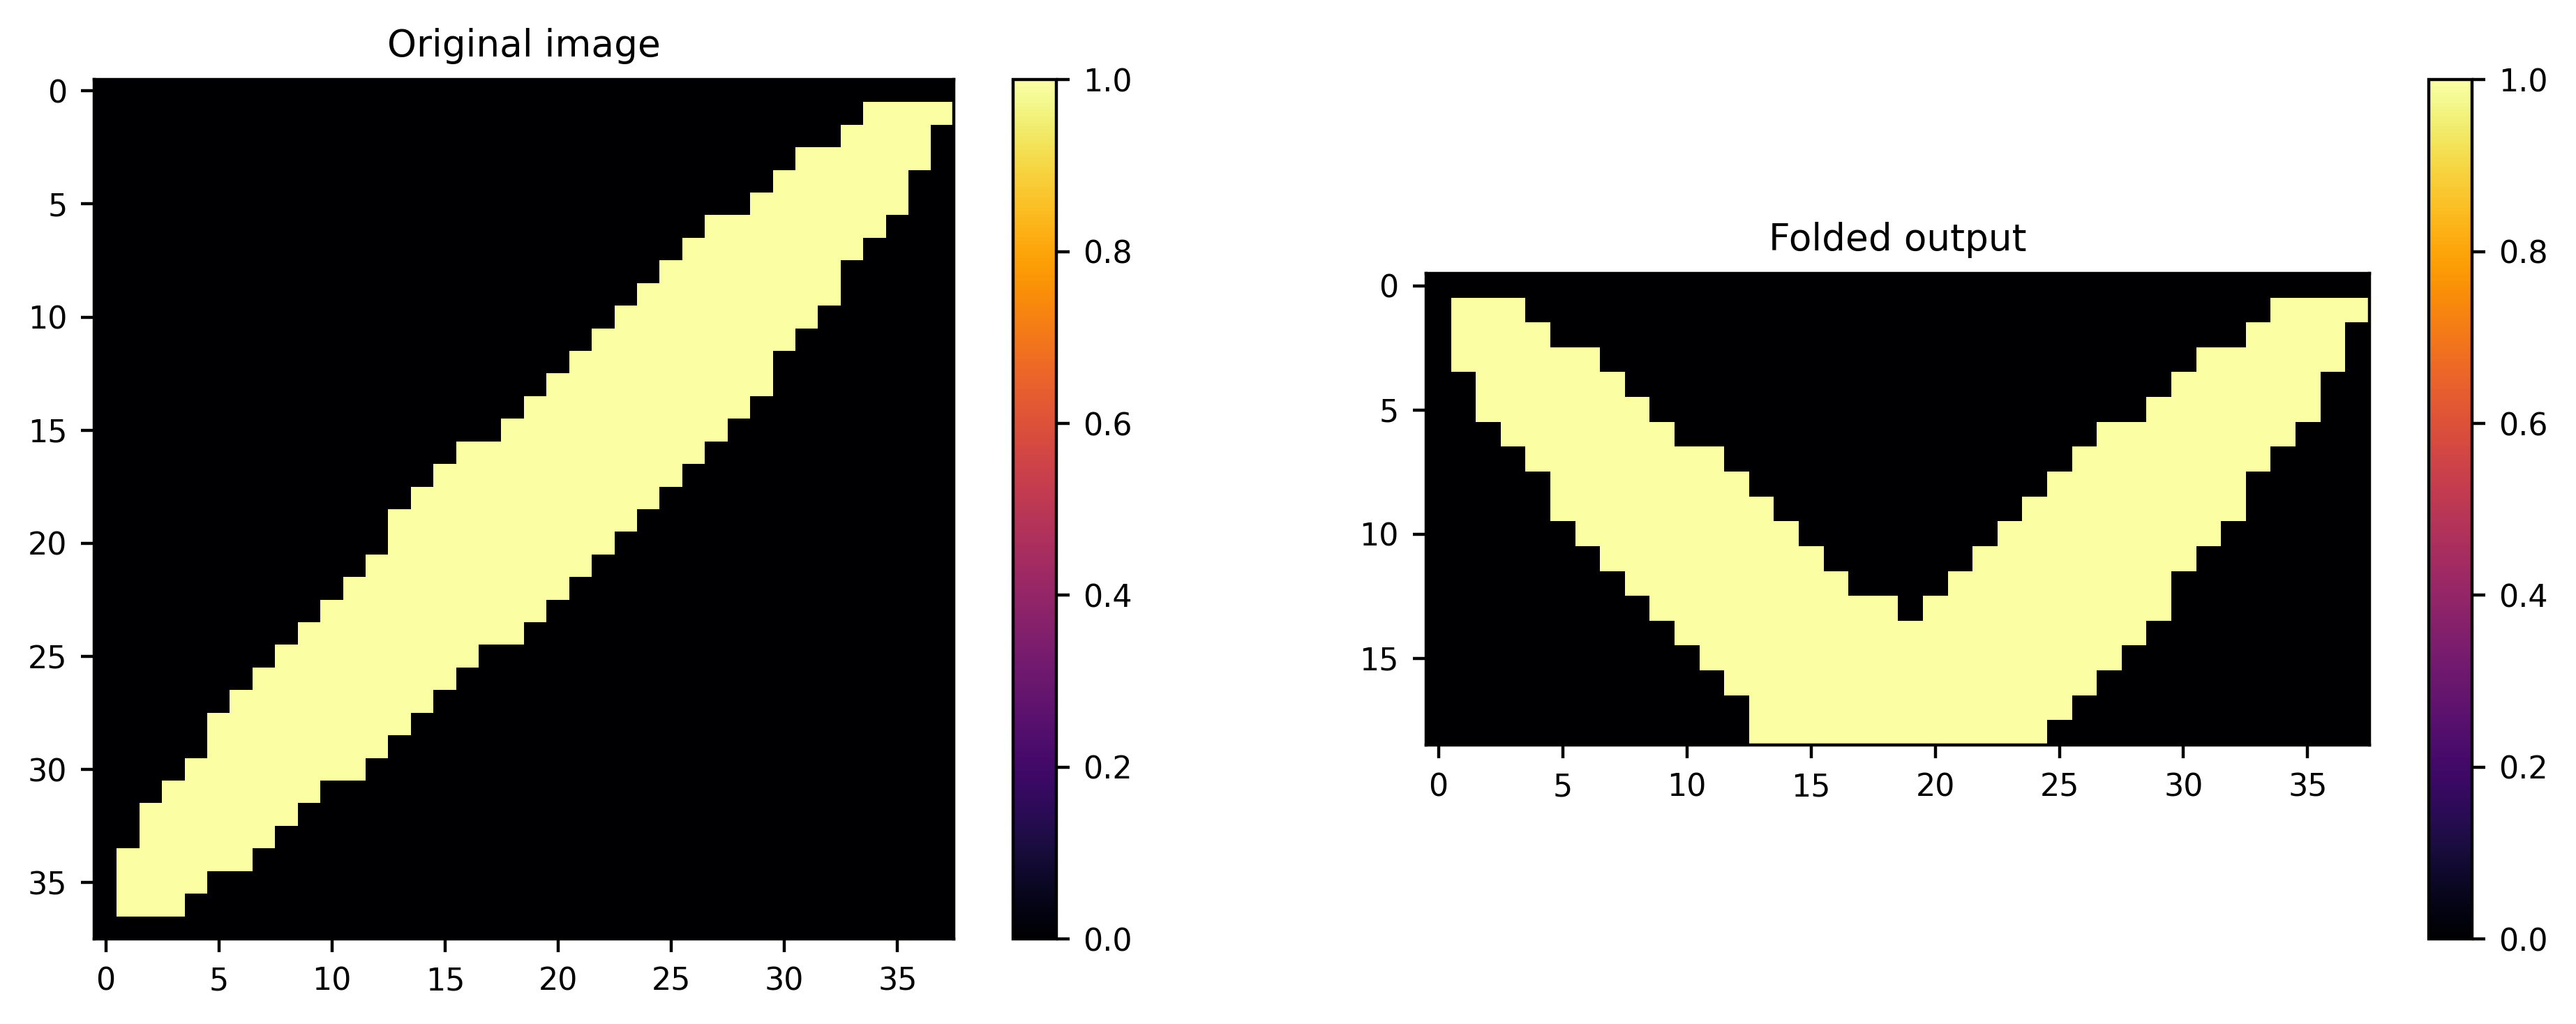

In [10]:
def fold_original_image_array(org_image_array):
    # Return an array containing folding each 2d shape
    # print('org_image_array = ',org_image_array.shape)
    folded_org_image_array = np.zeros((int(org_image_array.shape[0]),int(org_image_array.shape[1]/2),int(org_image_array.shape[2]) ))
    # print('folded_org_image_array = ',folded_org_image_array.shape)
    for i in np.arange(len(org_image_array)):
        image_top = org_image_array[i,0:int(org_image_array.shape[1]/2),:]
        # print('image_top.shape = ',image_top.shape)
        image_bottom = org_image_array[i,int(org_image_array.shape[1]/2):,:]
        # print("image_bottom.shape = ",image_bottom.shape)
        image_bottom_flip = np.flipud(image_bottom)
        # print('folded_org_image_array[i].shape = ',folded_org_image_array[i].shape)
        folded_org_image_array[i] = image_bottom_flip+image_top
    # folded_image_normalized = (folded_image - np.amin(folded_image))/(np.amax(folded_image) - np.amin(folded_image))
    folded_org_image_array[folded_org_image_array>0] = 1
    return(folded_org_image_array)

folded_test_shape_array = fold_original_image_array(test_shape)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

im = ax[0].imshow(test_shape[0], cmap='inferno')
ax[0].set_title('Original image')
plt.colorbar(im)

im = ax[1].imshow(folded_test_shape_array[0], cmap='inferno')
ax[1].set_title('Folded output')
plt.colorbar(im)

plt.show()

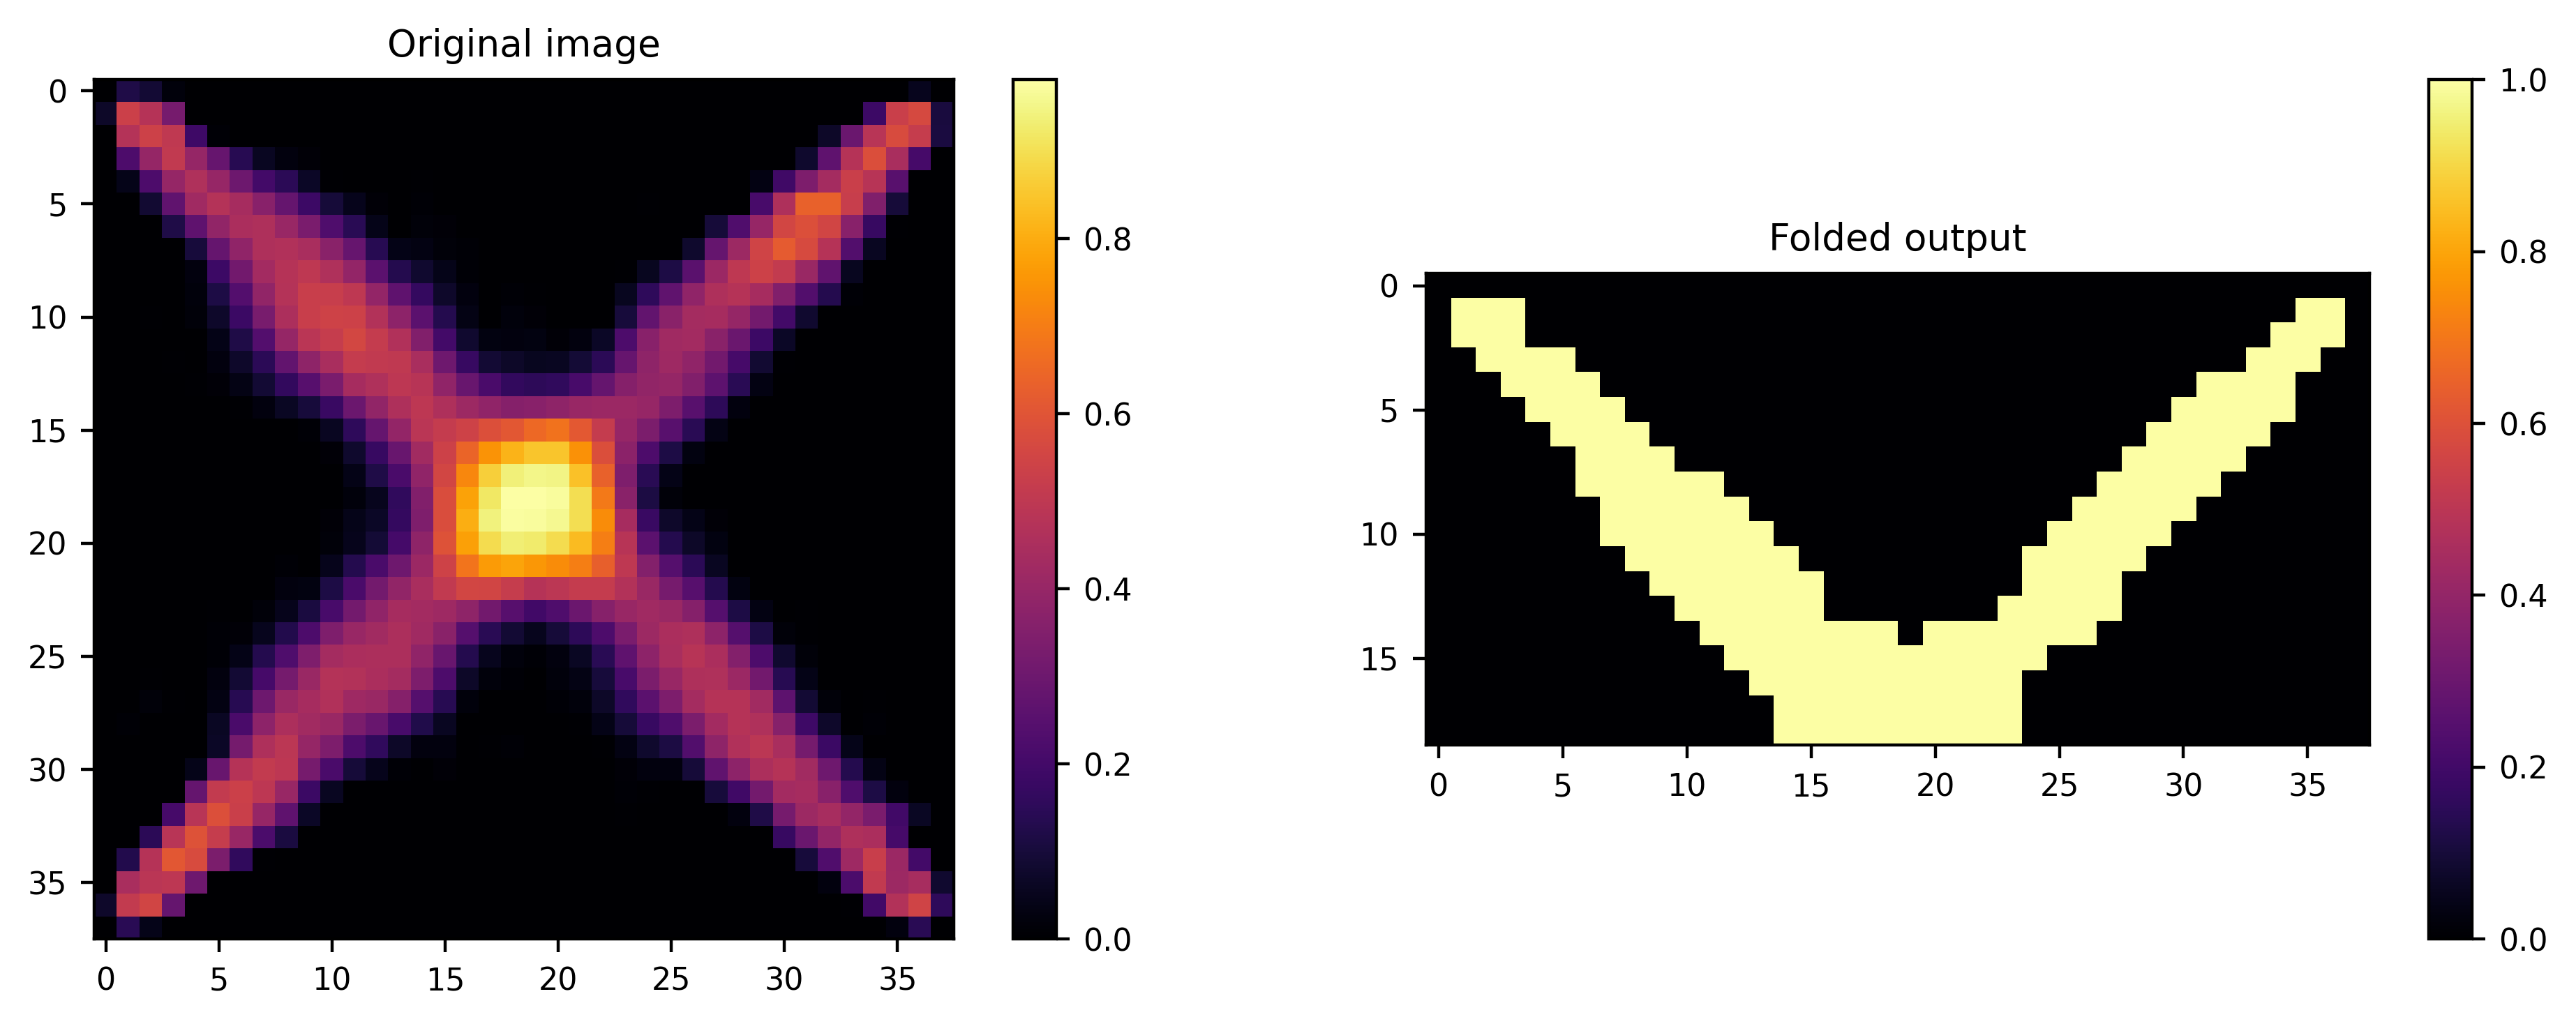

In [11]:
def fold_predicted_image_array(org_image_array):
    # Return an array containing folding each 2d shape
    folded_org_image_array = np.zeros((int(org_image_array.shape[0]),int(org_image_array.shape[1]/2),int(org_image_array.shape[2]) ))
    for i in np.arange(len(org_image_array)):
        image_top = org_image_array[i,0:int(org_image_array.shape[1]/2),:]
        image_bottom = org_image_array[i,int(org_image_array.shape[1]/2):,:]
        image_bottom_flip = np.flipud(image_bottom)
        folded_org_image_array[i] = image_bottom_flip+image_top
        folded_org_image_array[i] = (folded_org_image_array[i] - np.amin(folded_org_image_array[i]))/(np.amax(folded_org_image_array[i]) - np.amin(folded_org_image_array[i]))
    folded_org_image_array[folded_org_image_array>=0.3] = 1
    folded_org_image_array[folded_org_image_array<0.3] = 0
    return(folded_org_image_array)

folded_predicted_shape_array_SNR500 = fold_predicted_image_array(test_predict_shape_SNR500)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

im = ax[0].imshow(test_predict_shape_SNR500[0], cmap='inferno')
ax[0].set_title('Original image')
plt.colorbar(im)

im = ax[1].imshow(folded_predicted_shape_array_SNR500[0], cmap='inferno')
ax[1].set_title('Folded output')
plt.colorbar(im)

# bin_px = np.linspace(0,1,10)
# px = np.array(folded_predicted_shape_array_SNR500[0])
# temp = px.flatten()
# plt.hist(temp,bins=bin_px)

plt.show()

In [12]:
# All the required codes for folding and calculating MSE

def fold_original_image_array(org_image_array):
    # Return an array containing folding each 2d shape
    folded_org_image_array = np.zeros((int(org_image_array.shape[0]),int(org_image_array.shape[1]/2),int(org_image_array.shape[2]) ))
    for i in np.arange(len(org_image_array)):
        image_top = org_image_array[i,0:int(org_image_array.shape[1]/2),:]
        image_bottom = org_image_array[i,int(org_image_array.shape[1]/2):,:]
        image_bottom_flip = np.flipud(image_bottom)
        folded_org_image_array[i] = image_bottom_flip+image_top
    folded_org_image_array[folded_org_image_array>0] = 1
    return(folded_org_image_array)

def fold_predicted_image_array(org_image_array):
    threshold = 0.3
    # Return an array containing folding each 2d shape
    folded_org_image_array = np.zeros((int(org_image_array.shape[0]),int(org_image_array.shape[1]/2),int(org_image_array.shape[2]) ))
    for i in np.arange(len(org_image_array)):
        image_top = org_image_array[i,0:int(org_image_array.shape[1]/2),:]
        image_bottom = org_image_array[i,int(org_image_array.shape[1]/2):,:]
        image_bottom_flip = np.flipud(image_bottom)
        folded_org_image_array[i] = image_bottom_flip+image_top
        folded_org_image_array[i] = (folded_org_image_array[i] - np.amin(folded_org_image_array[i]))/(np.amax(folded_org_image_array[i]) - np.amin(folded_org_image_array[i]))
    folded_org_image_array[folded_org_image_array>=threshold] = 1
    folded_org_image_array[folded_org_image_array<threshold] = 0
    return(folded_org_image_array)

def calc_MSE(ary1,ary2):
    MSE = 0
    if ary1.shape == ary2.shape:
        for i in np.arange(len(ary1)):
            MSE = MSE + np.mean((ary1[i] - ary2[i])**2)
        MSE = MSE/len(ary1)
        # print("MSE = ",MSE)
        return(MSE)
    else:
        print("Given array shape not same")

# Fold the original shapes
folded_test_shape_array = fold_original_image_array(test_shape)

# Fold the predicted shapes for different SNR
folded_predicted_shape_array_SNR500 = fold_predicted_image_array(test_predict_shape_SNR500)
folded_predicted_shape_array_SNR200 = fold_predicted_image_array(test_predict_shape_SNR200)
folded_predicted_shape_array_SNR150 = fold_predicted_image_array(test_predict_shape_SNR150)
folded_predicted_shape_array_SNR100 = fold_predicted_image_array(test_predict_shape_SNR100)
folded_predicted_shape_array_SNR75 = fold_predicted_image_array(test_predict_shape_SNR75)
folded_predicted_shape_array_SNR50 = fold_predicted_image_array(test_predict_shape_SNR50)


print("MSE without folding")
mse = calc_MSE(test_shape,test_predict_shape_SNR500)
print("SNR = 500 -> ",mse)
mse = calc_MSE(test_shape,test_predict_shape_SNR200)
print("SNR = 200 -> ",mse)
mse = calc_MSE(test_shape,test_predict_shape_SNR150)
print("SNR = 150 -> ",mse)
mse = calc_MSE(test_shape,test_predict_shape_SNR100)
print("SNR = 100 -> ",mse)
mse = calc_MSE(test_shape,test_predict_shape_SNR75)
print("SNR = 75 -> ",mse)
mse = calc_MSE(test_shape,test_predict_shape_SNR50)
print("SNR = 50 -> ",mse)


print("MSE after folding the shape")
mse = calc_MSE(folded_test_shape_array,folded_predicted_shape_array_SNR500)
print("SNR = 500 -> ",mse)
mse = calc_MSE(folded_test_shape_array,folded_predicted_shape_array_SNR200)
print("SNR = 200 -> ",mse)
mse = calc_MSE(folded_test_shape_array,folded_predicted_shape_array_SNR150)
print("SNR = 150 -> ",mse)
mse = calc_MSE(folded_test_shape_array,folded_predicted_shape_array_SNR100)
print("SNR = 100 -> ",mse)
mse = calc_MSE(folded_test_shape_array,folded_predicted_shape_array_SNR75)
print("SNR = 75 -> ",mse)
mse = calc_MSE(folded_test_shape_array,folded_predicted_shape_array_SNR50)
print("SNR = 50 -> ",mse)


MSE without folding
SNR = 500 ->  0.11103931283472526
SNR = 200 ->  0.11950487824046095
SNR = 150 ->  0.12359505673591473
SNR = 100 ->  0.1330721929914302
SNR = 75 ->  0.13805018028258625
SNR = 50 ->  0.15330118609475535
MSE after folding the shape
SNR = 500 ->  0.08545706371191135
SNR = 200 ->  0.10699722991689749
SNR = 150 ->  0.11643213296398892
SNR = 100 ->  0.13811080332409972
SNR = 75 ->  0.14332963988919656
SNR = 50 ->  0.17117451523545704
